<a href="https://colab.research.google.com/github/thibautboyenval/reinforcement-learning-rainbow/blob/main/rainbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APM_53670 - Reinforcement Learning
**BOYENVAL Thibaut**
___

This notebook accompanies the report summarizing the paper [Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/pdf/1710.02298). It contains an implementation of the Rainbow agent based on a DQN algorithm with the extensions proposed in the paper:
- Double Q-learning
- Prioritized replay
- Dueling networks
- Multi-step learning
- Distributional RL
- Noisy Nets

This notebook is based on the work from:
1. https://github.com/higgsfield/RL-Adventure/tree/master.
2. https://github.com/Kaixhin/Rainbow/tree/master

We will use for experiments **CartPole** environment from "Classic Control" environments of Gymnasium:

><img src="https://gymnasium.farama.org/_images/cart_pole.gif" alt="CartPole balancing" width="200">
>
>The **CartPole** environment in Gymnasium is a classic control problem used for testing reinforcement learning algorithms. The task is to balance a pole attached to a cart by applying forces to move the cart left or right along a one-dimensional track.
>
> **Environment Details:**
>
>- **Objective**: Prevent the pole from falling over by keeping it balanced upright for as long as possible.
- **Action Space**: Discrete
  - `0`: Move the cart to the left.
  - `1`: Move the cart to the right.
- **Observation Space**: A continuous 4-dimensional space representing:
  1. Cart position (`x`): Horizontal position of the cart.
  2. Cart velocity (`x_dot`): Speed of the cart along the track.
  3. Pole angle (`theta`): Angle of the pole relative to vertical.
  4. Pole angular velocity (`theta_dot`): Rate of change of the pole's angle.
- **Reward**:
  - +1 for every time step the pole remains balanced.
  - The goal is to maximize the cumulative reward.
- **Termination Conditions**:
  - The pole angle exceeds ±12 degrees from vertical.
  - The cart's position moves more than ±2.4 units from the center of the track.
  - Episode length exceeds 500 time steps (depending on configuration).
- **Physics**: The environment simulates a simplified physical system based on a frictionless track and pole dynamics.

## Import Libraries

In [1]:
import sys
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple
import base64
import glob
import io
from IPython.display import HTML, display

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

if IN_COLAB:
    !wget https://raw.githubusercontent.com/thibautboyenval/reinforcement-learning-rainbow/master/utils.py

from utils import MinSegmentTree, SumSegmentTree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

## **1. N-Step Learning**

The key idea is to replace the single-step TD target with an n-step return. Instead of looking at just the immediate reward, the agent considers the sum of rewards over n steps, followed by the discounted value of the state at the n-th step:

$$
R^{(n)}_t = \sum_{k=0}^{n-1} \gamma_t^{(k)} R_{t+k+1}.
$$

The corresponding loss function becomes:

$$
(R^{(n)}_t + \gamma^{(n)}_t \max_{a'} q_{\theta}^{-}
(S_{t+n}, a')
- q_{\theta}(S_t, A_t))^2.
$$

N-step learning with suitably tuned $n$ often lead to faster learning.

To implement N-step learning we have to store transitions after n steps. To do so we can use `deque` to store the most recent N-step transitions.

We doen't actually store a transition in the buffer, unless `n_step_buffer` is full.

When the length of `n_step_buffer` becomes equal to N, it eventually stores the N-step transition, which is calculated by `_get_n_step_info` method.

In [2]:
class ReplayBuffer:

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        n_step: int = 1,
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) < self.n_step:
            return ()

        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]

        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            indices=idxs,
        )

    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

## **2. Prioritized Replay Buffer**

Experience replay is a critical component of Deep Q-Networks, designed to improve sample efficiency and reduce the correlation between consecutive experiences. However, the standard experience replay samples experiences uniformly, which may not be optimal. Not all transitions in the replay buffer contribute equally to learning:
- Some transitions provide more significant learning signals (e.g., when the current Q-value is far from the target Q-value).
- Uniform sampling treats all experiences equally, which can slow down convergence by over-sampling redundant or less informative transitions.
Prioritized Experience Replay (Schaul et al., 2016) addresses this limitation by prioritizing transitions based on their learning potential, enabling the agent to focus on more informative experiences.

The main idea is to assign a priority $p_i$ to each transition i in the replay buffer, where $p_i$ reflects the importance of the transition. Transitions with higher priorities are sampled more frequently during training.
The priority $p_i$ is typically proportional to the Temporal Difference error:

$$p_i = |\delta_i| + \epsilon$$ where

$$
\delta_i = |r_i + \gamma.\text{max } q(s_i^{'}, a^{'}, \bar\theta) - q(s_i, a_i, \theta)| $$


and $\epsilon$ is a small positive constant to ensure numerical stability.

Transitions are sampled from the replay buffer using a probability distribution proportional to their priorities:

$$
P(i) = \frac{p_i^{\alpha}}{\sum_k p_k^{\alpha}}
$$

The exponent $\alpha$ determines how much prioritization is used, with $\alpha = 0$ corresponding to the uniform case.

Prioritized sampling introduces a bias because it over-samples certain transitions. To correct this, importance sampling weights are applied during gradient updates:

$$
w_i = \big( \frac{1}{N} \cdot \frac{1}{P(i)} \big)^\beta
$$

that fully compensates for the non-uniform probabilities $P(i)$ if $\beta = 1$. As the unbiased nature of the updates is most important near convergence at the end of training, we exploit the flexibility of annealing the amount of importance-sampling correction over time, by defining a schedule on the exponent $\beta$ that reaches 1 only at the end of learning.

In [3]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight

    """

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        alpha: float = 0.6,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
        self,
        obs: np.ndarray,
        act: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )

    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

## **3. Noisy Layer**

Noisy Networks replace the fully connected layers in a DQN architecture with noisy layers, enabling exploration directly through parameter perturbations. This eliminates the need for $\epsilon$-greedy exploration.

A linear layer of a neural network with $p$ inputs and $q$ outputs, represented by

$$
y = wx + b,
$$

where $x \in \mathbb{R}^p$ is the layer input, $w \in \mathbb{R}^{q \times p}$, and $b \in \mathbb{R}$ the bias

is replaced by

$$
y = (\mu^w + \sigma^w \odot \epsilon^w) x + \mu^b + \sigma^b \odot \epsilon^b,
$$

where $\mu^w + \sigma^w \odot \epsilon^w$ and $\mu^b + \sigma^b \odot \epsilon^b$ replace $w$ and $b$ in the first linear layer equation. The parameters $\mu^w \in \mathbb{R}^{q \times p}, \mu^b \in \mathbb{R}^q, \sigma^w \in \mathbb{R}^{q \times p}$ and $\sigma^b \in \mathbb{R}^q$ are learnable, whereas $\epsilon^w \in \mathbb{R}^{q \times p}$ and $\epsilon^b \in \mathbb{R}^q$ are noise random variables.

The choice of noise distribution is critical for stable training. A common approach is to use factorized Gaussian noise. This is a more computationally efficient way. It produces 2 random Gaussian noise vectors ($p, q$) and makes $pq + q$ noise entries by outer product as follows:

$$
\begin{align}
\epsilon_{i,j}^w &= f(\epsilon_i) f(\epsilon_j),\\
\epsilon_{j}^b &= f(\epsilon_i),\\
\text{where } f(x) &= sgn(x) \sqrt{|x|}.
\end{align}
$$

In [4]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.



    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

## **4. Distributional RL**

Most of RL algorithms use expected return for a given state-action pair. However, this approach focuses solely on the mean return, ignoring the underlying distribution of possible returns.

Since the true return distribution is typically continuous and complex, distributional RL algorithms approximate it using parameterized distributions.

Categorical representation models such distributions with probability masses placed on a discrete support $z$, where $z$ is a vector with $N_{atoms} \in \mathbb{N}^+$ atoms, defined by $z_i = V_{min} + (i-1) \frac{V_{max} - V_{min}}{N-1}$ for $i \in \{1, ..., N_{atoms}\}$.

The training process involves minimizing the divergence between the predicted and target distributions under the distributional Bellman operator. The categorical approach (C51) uses a projection step to align the target distribution with the fixed atoms:

$$
d_t' = (R_{t+1} + \gamma_{t+1} z, p_\hat{{\theta}} (S_{t+1}, \hat{a}^{*}_{t+1})),\\
D_{KL} (\phi_z d_t' \| d_t).
$$

Here $\phi_z$ is a L2-projection of the target distribution onto the fixed support $z$, and $\hat{a}^*_{t+1} = \arg\max_{a} q_{\hat{\theta}} (S_{t+1}, a)$ is the greedy action with respect to the mean action values $q_{\hat{\theta}} (S_{t+1}, a) = z^{T}p_{\theta}(S_{t+1}, a)$ in state $S_{t+1}$.

The parametrized distribution can be represented by a neural network, as in DQN, but with atom_size x out_dim outputs. A softmax is applied independently for each action dimension of the output to ensure that the distribution for each action is appropriately normalized.

To estimate q-values, we use inner product of each action's softmax distribution and support which is the set of atoms $\{z_i = V_{min} + i\Delta z: 0 \le i < N\}, \Delta z = \frac{V_{max} - V_{min}}{N-1}$.

$$
Q(s_t, a_t) = \sum_i z_i p_i(s_t, a_t)
$$
where $p_i$ is the probability of $z_i$ (the output of softmax).

## **5. Dueling Network**

Dueling Network Architectures (Wang et al., 2016) separately estimates:
- State-value function $V^\pi (s)$: The intrinsic value of being in a state s, irrespective of the action.
- Advantage function $A^\pi (s, a)$: The relative importance of taking a specific action a compared to others at state s.
The Q-function is decomposed as:


$$Q^\pi (s, a) = A^\pi (s, a) + V^\pi (s).$$

The value function $V$ measures the how good it is to be in a particular state $s$. The $Q$ function, however, measures the the value of choosing a particular action when in this state.

To enforce identifiability (i.e., ensuring the decomposition is unique), the advantage function is normalized, typically using a mean subtraction:

$$
Q(s, a; \theta, \alpha, \beta) = V (s; \theta, \beta) + \big( A(s, a; \theta, \alpha) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a'; \theta, \alpha) \big).
$$

In [5]:
class Network(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

## **6. Double DQN**

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Here, we use `self.dqn` instead of `self.dqn_target` to obtain the target actions.

```
        # Categorical DQN + Double DQN
        # target_dqn is used when we don't employ double DQN
        next_action = self.dqn(next_state).argmax(1)
        next_dist = self.dqn_target.dist(next_state)
        next_dist = next_dist[range(self.batch_size), next_action]
```

## **Rainbow Agent**



In [11]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        n_step: int = 3,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha, gamma=gamma
        )

        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )

        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.Adam(self.dqn.parameters())

        self.transition = list()

        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]

            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            else:
                one_step_transition = self.transition

            if one_step_transition:
                self.memory.store(*one_step_transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]

        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)

        loss = torch.mean(elementwise_loss * weights)

        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss

            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward


            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True

        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.subplot(132)
        plt.title('Loss')
        plt.xlabel('Frame')
        plt.ylabel('Loss')
        plt.plot(losses)
        plt.show()


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

## **Test of the Agent**


In [12]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

In [13]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

In [14]:
# parameters
num_frames = 10000
memory_size = 10000
batch_size = 128
target_update = 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, seed)

cuda


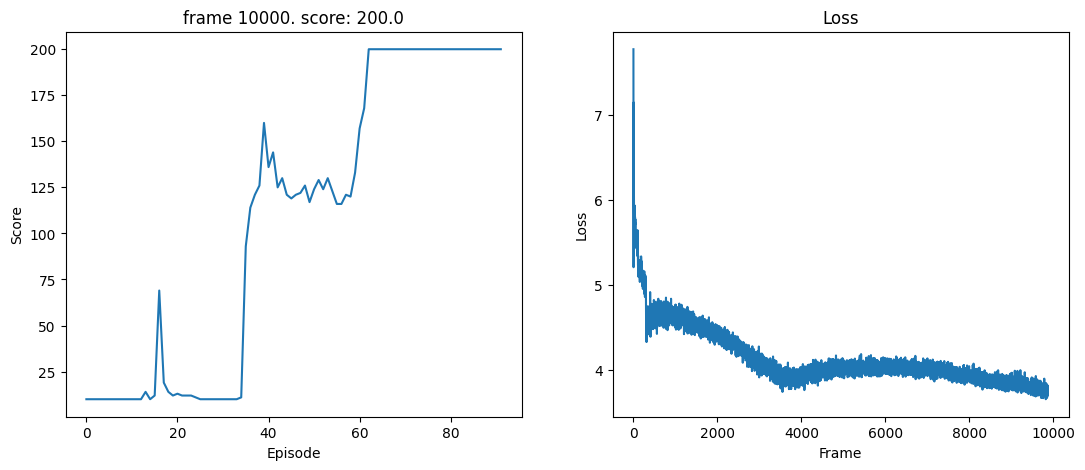

In [15]:
agent.train(num_frames)

In [16]:
video_folder="videos/rainbow"
agent.test(video_folder=video_folder)

Moviepy - Building video /content/videos/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rainbow/rl-video-episode-0.mp4
score:  200.0


In [17]:
latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/rainbow/rl-video-episode-0.mp4
